In [1]:
import os

os.chdir('../')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import ssq_stft, issq_stft
from model.vae import VAEModel
from model.encoder import VAE_Encoder
from model.decoder import VAE_Decoder
# from model.fconnected import Fully_connected

In [3]:
device = ['cuda' if torch.cuda.is_available() else 'cpu'][0]
shape = (2, 128, 128)
generator = torch.Generator(device=device)
generator.manual_seed(42)

encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
# fully_connected = Fully_connected().to(device)
model = VAEModel(encoder, decoder, shape, device, generator)

model.load_state_dict(torch.load('checkpoints/vae'))

<All keys matched successfully>

In [8]:
print(model)

VAEModel(
  (encoder): VAE_Encoder(
    (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (2): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      

In [129]:
data = np.load('../Dataset/CleanDataset.npy')
train = data[:int(len(data) * 0.8), :]
test = data[int(len(data) * 0.8):int(len(data) * 0.9), :]
val = data[int(len(data) * 0.9):, :]

test_input = test[100, :128]
inputs = np.empty((1, *shape))

Twxo, TF, *_ = ssq_stft(test_input, n_fft=256)
inputs[0, 0, :, :] = TF.real[0:128, :]
inputs[0, 1, :, :] = TF.imag[0:128, :]
v = inputs[0, :, :, :]
inputs[0 :, :, :] = (v - v.min()) / (v.max() - v.min())

In [130]:
input_image_tensor = torch.tensor(inputs, dtype=torch.float32, device=device)
mean, stdev, output_r = model(input_image_tensor)

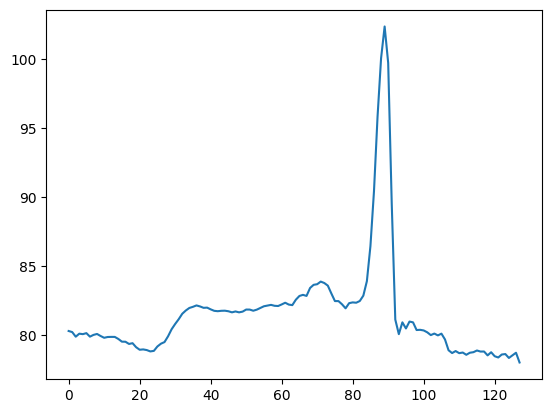

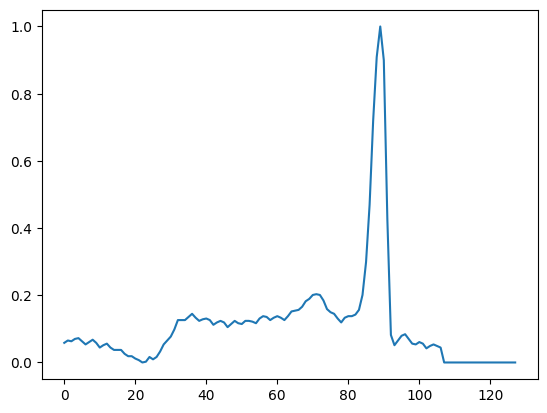

In [131]:
my_img = output_r[0, 0] + output_r[0, 1] * 1j
my_sig = issq_stft(my_img)

plt.plot(torch.Tensor(my_sig).to('cpu').detach().numpy())
plt.show()

plt.plot(test_input)
plt.show()

In [18]:
def add_noise(original_samples: torch.FloatTensor, timesteps: torch.IntTensor, generator) -> torch.FloatTensor:
    betas = torch.linspace(0.00085 ** 0.5, 0.0120 ** 0.5, 1000, dtype=torch.float32) ** 2
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod = alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
    timesteps = timesteps.to(original_samples.device)

    sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()

    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
        sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

    sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    noise = torch.randn(original_samples.shape, generator=generator, device=original_samples.device, dtype=original_samples.dtype)
    noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise

    return noisy_samples


original_samples = torch.rand((2, 2, 128, 128), dtype=torch.float32, device=device)
timesteps = torch.from_numpy(np.arange(0, 1000)[::-1].copy())
my_test = add_noise(original_samples, timesteps[-1], generator)

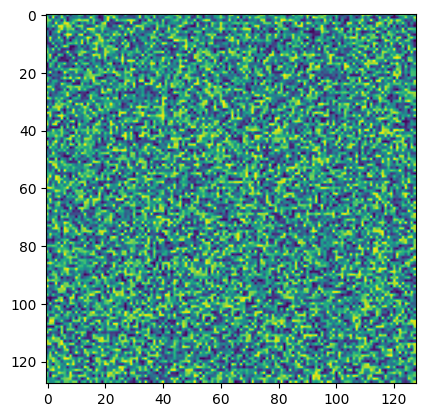

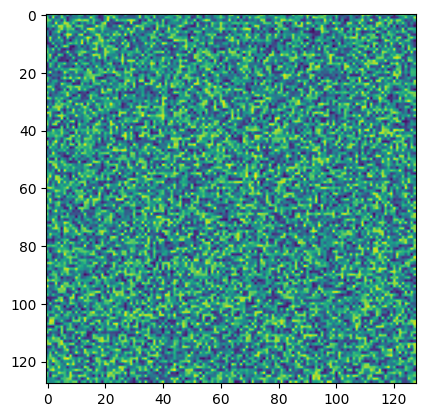

In [19]:
plt.imshow(original_samples[0, 0].cpu())
plt.show()

plt.imshow(my_test[0, 0].cpu())
plt.show()